In [1]:
%matplotlib inline

In [2]:
from __future__ import absolute_import
from __future__ import print_function,division
import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt
import os,time

import theano

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import adagrad
from keras.callbacks import ModelCheckpoint

from sklearn.cross_validation import ShuffleSplit

In [3]:
"""
t1=time.time()
rt='/home/michelle/Dropbox/Project/DES_images/data/'
X_train=np.load(rt+'X_train.npy')
X_val=np.load(rt+'X_val.npy')
X_test=np.load(rt+'X_test.npy')

Y_train=np.load(rt+'Y_train.npy')
Y_val=np.load(rt+'Y_val.npy')
Y_test=np.load(rt+'Y_test.npy')
print('Read data in ',time.time()-t1,'s')
"""

"\nt1=time.time()\nrt='/home/michelle/Dropbox/Project/DES_images/data/'\nX_train=np.load(rt+'X_train.npy')\nX_val=np.load(rt+'X_val.npy')\nX_test=np.load(rt+'X_test.npy')\n\nY_train=np.load(rt+'Y_train.npy')\nY_val=np.load(rt+'Y_val.npy')\nY_test=np.load(rt+'Y_test.npy')\nprint('Read data in ',time.time()-t1,'s')\n"

In [4]:
t1=time.time()
rt='/home/michelle/Dropbox/Project/DES_images/data/'
X=np.load(rt+'SVA1_multiclass_images.npy')
Y=np.load(rt+'SVA1_multiclass_classes.npy')

nb_classes = len(np.unique(Y))
print('Number of classes',nb_classes)

ss = ShuffleSplit(len(Y), n_iter=1,test_size=0.4)
mylist = list(ss)
train, test = mylist[0]

#I actually want to split the "test" into validation and test
val=test[:(int)(0.75*len(test))]
test=test[(int)(0.75*len(test)):]

X_train=X[train]
Y_train=Y[train]
X_val=X[val]
Y_val=Y[val]
X_test=X[test]
Y_test=Y[test]

print('Read data in ',time.time()-t1,'s')

Number of classes 12
Read data in  0.0989861488342 s


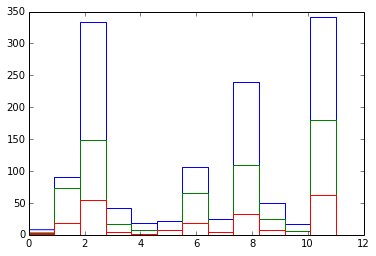

In [5]:
#Check the training set is representative
plt.hist(Y_train,nb_classes,facecolor='none',edgecolor='b');
plt.hist(Y_val,nb_classes,facecolor='none',edgecolor='g');
plt.hist(Y_test,nb_classes,facecolor='none',edgecolor='r');

In [6]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_val = np_utils.to_categorical(Y_val, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

In [7]:
#X_train=X_train[:,:,:50,:]
#X_val=X_val[:,:,:50,:]
#X_test=X_test[:,:,:50,:]

In [8]:
batch_size = 50 
nb_epoch = 20

# shape of the image (SHAPE x SHAPE)
shapex, shapey = X_train[0].shape[-2],X_train[0].shape[-1]
#print(X_train.shape)
print(shapex,shapey)
# number of convolutional filters to use
nb_filters = 32 #32
# level of pooling to perform (POOL x POOL)
nb_pool = 2
# level of convolution to perform (CONV x CONV)
nb_conv = 3

51 102


In [9]:
#plt.imshow(X_train[1][0],cmap='gray')

In [10]:
model = Sequential()

model.add(Convolution2D(nb_filters, 1, nb_conv, nb_conv, border_mode='full'))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, nb_filters, nb_conv, nb_conv))
convout1=Activation('relu')
model.add(convout1)
model.add(MaxPooling2D(poolsize=(nb_pool, nb_pool)))
model.add(Dropout(0.4))

model.add(Convolution2D(nb_filters,nb_filters, nb_conv, nb_conv, border_mode='full'))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, nb_filters, nb_conv, nb_conv))
convout2=Activation('relu')
model.add(convout2)
model.add(MaxPooling2D(poolsize=(nb_pool, nb_pool)))
model.add(Dropout(0.75))

model.add(Flatten())
# the resulting image after conv and pooling is the original shape
# divided by the pooling with a number of filters for each "pixel"
# (the number of filters is determined by the last Conv2D)
model.add(Dense(nb_filters * (shapex // nb_pool//nb_pool) * (shapey // nb_pool//nb_pool), 128))
#model.add(Dense(nb_filters * (shapex // nb_pool) * (shapey // nb_pool), 128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#Gilles suggested adding an extra set of layers here to improve accuracy
model.add(Dense(128, 128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(128, nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adadelta')
#ad=adagrad(clipnorm=1)
#model.compile(loss='mean_squared_error', optimizer=ad)
#model.compile(loss='categorical_crossentropy', optimizer=ad)



In [ ]:
#model.get_config()
fname='model.hdf5'

In [ ]:
checkpointer=ModelCheckpoint(fname, verbose=0, save_best_only=True)
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch, show_accuracy=True, verbose=1, validation_data=(X_val, Y_val),callbacks=[checkpointer])
score = model.evaluate(X_test, Y_test, show_accuracy=True, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 1290 samples, validate on 645 samples
Epoch 0
  50/1290 [>.............................] - ETA: 211s - loss: 14.0099 - acc: 0.0400

In [ ]:
#model=Sequential()
#model.load_weights(fname)

In [ ]:
y_fit=model.predict(X_test)

In [ ]:
y_fit=y_fit.argmax(axis=1)

In [ ]:
Y_test=np.load(rt+'Y_test.npy')

In [ ]:
np.sum(Y_test==y_fit)/len(Y_test)

In [ ]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    plt.colorbar(im, cax=cax)

In [ ]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

In [ ]:
convout1_f = theano.function([model.get_input(train=False)], convout1.get_output(train=False))
#convout2_f = theano.function([model.get_input(train=False)], convout2.get_output(train=False))

In [ ]:
ind=10
plt.imshow(X_test[ind][0],cmap='gray')
plt.title(Y_test[ind])

In [ ]:
C1 = convout1_f(X_test[ind:ind+1])
C1 = np.squeeze(C1)
print("C1 shape : ", C1.shape)

plt.figure(figsize=(15, 15))
#plt.suptitle('convout1')
nice_imshow(plt.gca(), make_mosaic(C1, 6, 6,border=1), cmap='gray')

In [ ]:
C2 = convout2_f(X_test[ind:ind+1])
C2 = np.squeeze(C2)
print("C2 shape : ", C2.shape)

plt.figure(figsize=(15, 15))
#plt.suptitle('convout1')
nice_imshow(plt.gca(), make_mosaic(C2, 6, 6,border=1), cmap='gray')